In [ ]:
import pickle
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms,models,datasets
from glob import glob
from IPython.display import clear_output
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

print(device)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cuda


# Создание датасета

In [ ]:
!unzip ./drive/MyDrive/data.zip -d ./
clear_output()

Подгружаем обработанные данные с гугл диска

## Обработка данных

In [ ]:
data1 = pd.read_csv("dataset/data.csv")

In [ ]:
data1 = data1.loc[(data1.obj != "Dog") & (data1.obj != "Wolverine")]  # в классах по 10-20 записей

In [ ]:
le = LabelEncoder()
data1.obj = le.fit_transform(data1.obj)  # заменяем str лэйблы на int

<ipython-input-37-a6319865e1d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.obj = le.fit_transform(data1.obj)


In [ ]:
data1 = data1.sample(frac=1).reset_index(drop=True)  # перемешиваем датасет

In [ ]:
data1.obj.value_counts().to_dict()

{14: 6683,
 10: 5024,
 9: 1856,
 13: 1709,
 1: 1282,
 11: 969,
 5: 890,
 4: 633,
 6: 507,
 18: 412,
 2: 200,
 7: 200,
 17: 190,
 8: 133,
 3: 106,
 12: 66,
 16: 47,
 15: 43,
 0: 38}

In [67]:
data1 = data1.groupby('obj').apply(lambda x: x.sample(n=500, replace=True if len(x) < 500 else False)).reset_index(drop=True)  # балансируем классы

([<matplotlib.patches.Wedge at 0x79456788ab00>,
 [Text(1.0849974335199486, 0.1810540506454493, '0'),
  Text(0.9674211243922347, 0.5235421359161692, '1'),
  Text(0.7450097238033291, 0.8092963063294478, '2'),
  Text(0.44186495843136075, 1.0073506631309934, '3'),
  Text(0.09083726786510439, 1.0962429433144842, '4'),
  Text(-0.27003405030511335, 1.066340288873967, '5'),
  Text(-0.6016429886827079, 0.920883116453407, '6'),
  Text(-0.8680545728210498, 0.6756339679178844, '7'),
  Text(-1.0403989733508354, 0.3571693943362559, '8'),
  Text(-1.0999999999999999, -2.5747358288378247e-08, '9'),
  Text(-1.0403989566305283, -0.35716944304084625, '10'),
  Text(-0.8680545411923404, -0.6756340085544508, '11'),
  Text(-0.6016429455730575, -0.9208831446183469, '12'),
  Text(-0.27003400038612196, -1.066340301515172, '13'),
  Text(0.09083731918393988, -1.0962429390620836, '14'),
  Text(0.4418650055888479, -1.0073506424458007, '15'),
  Text(0.7450097616892225, -0.809296271453025, '16'),
  Text(0.967421148901

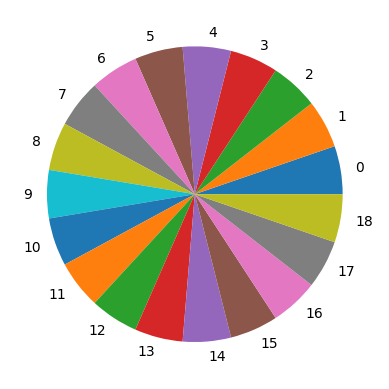

In [ ]:
fig, ax = plt.subplots()
ax.pie(data1.obj.value_counts().to_dict().values(), labels=data1.obj.value_counts().to_dict().keys());
# график распределения классов

In [ ]:
data1.shape

(9500, 2)

In [ ]:
with open("le.bf", "wb") as file:
    pickle.dump(le, file)

In [ ]:
data1.nunique()

name    5760
obj       19
dtype: int64

In [ ]:
train, val = train_test_split(
    data1, test_size=0.10, random_state=42)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data, mode="train"):
        data.sample(frac=1)
        self.mode = mode
        self.fpaths = data.name.apply(lambda x: "dataset/images/" + x).to_numpy()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        self.targets = F.one_hot(torch.tensor(data.obj.to_numpy()))  # one-hot encoding для нейросети

    def __len__(self):
      return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)
        im = cv2.resize(im, (360, 360))
        im = torch.tensor(im / 255)
        im = im.permute(2, 0, 1)  # (360, 360, 3) -> (3, 360, 360)
        im = im.float()

        if self.mode == "train":
              # ранее мы дополнили датасет новыми записями, теперь, чтобы данные были уникальными, добавим аугментацию
              augmentations = transforms.Compose([
                  transforms.RandomHorizontalFlip(p=0.5),  # Случайное горизонтальное отражение
                  # transforms.RandomVerticalFlip(p=0.5),  # Случайное вертикальное отражение
                  transforms.RandomRotation(degrees=30),  # Случайный поворот на ±30 градусов
                  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Изменение яркости, контрастности, насыщенности и оттенка
                  # transforms.RandomCrop(size=(360, 360), padding=4),  # Случайное обрезание с заполнением
              ])
              transform = transforms.Compose([
                  augmentations,
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
              ])

        else:
            transform = transforms.Compose([
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        im = transform(im)

        return im.to(device), target.float().to(device)

In [ ]:
data = CustomDataset(train)

In [ ]:
data.__len__()

8550

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.], device='cuda:0')


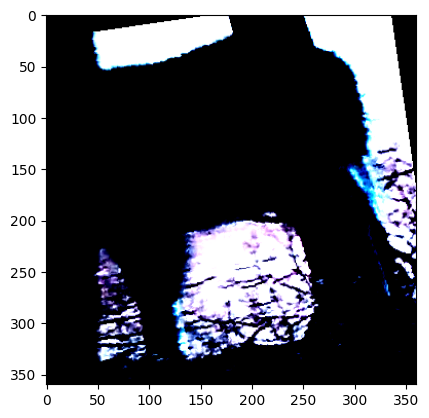

In [ ]:
im, label = data[0]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
def get_model():
    model = models.vgg19(pretrained=True)
    print(model)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 19)
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
    return model.to(device), loss_fn, optimizer

In [ ]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,360, 360))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 11, 11]         --
|    └─Conv2d: 2-1                       [-1, 64, 360, 360]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 360, 360]        --
|    └─Conv2d: 2-3                       [-1, 64, 360, 360]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 360, 360]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 180, 180]        --
|    └─Conv2d: 2-6                       [-1, 128, 180, 180]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 180, 180]       --
|    └─Conv2d: 2-8                       [-1, 128, 180, 180]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 180, 180]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 90, 90]         --
|    └─Conv2d: 2-11                      [-1, 256, 90, 90]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 90,

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    optimizer.zero_grad()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    prediction = nn.functional.softmax(prediction, dim=1)
    prediction = torch.argmax(prediction, dim=1)

    y_classes = torch.argmax(y, dim=1)
    correct_predictions = (prediction == y_classes)
    # print(y_classes)
    accuracy = correct_predictions.float()
    return accuracy.cpu().numpy().tolist()

In [ ]:
def get_data():
    train1 = CustomDataset(train)
    trn_dl = DataLoader(train1, batch_size=128, shuffle=True, drop_last=True)
    val1 = CustomDataset(val, mode="val")
    val_dl = DataLoader(val1, batch_size=128, shuffle=True, drop_last=True)
    return trn_dl, val_dl

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
from tqdm.auto import tqdm

In [ ]:
data1.obj.nunique()

19

In [60]:
train_losses, train_accuracies = [], []
val_accuracies = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
print("All losses and accuracies are for each epoch")
for epoch in tqdm(range(100)):  # starts from the 7th epoch

    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    try:
        for ix, batch in tqdm(enumerate(iter(trn_dl)), total=len(trn_dl)):
            # print(batch)
            x, y = batch
            # print(x.shape, y.shape)
            batch_loss = train_batch(x, y, model, optimizer, loss_fn)
            train_epoch_losses.append(batch_loss)

            is_correct = accuracy(x, y, model)

            train_epoch_accuracies.extend(is_correct)

        train_epoch_loss = np.array(train_epoch_losses).mean()
        train_epoch_accuracy = np.mean(train_epoch_accuracies)

        for ix, batch in tqdm(enumerate(iter(val_dl)), total=len(val_dl)):
            x, y = batch
            val_is_correct = accuracy(x, y, model)
            val_epoch_accuracies.extend(val_is_correct)
        val_epoch_accuracy = np.mean(val_epoch_accuracies)
        scheduler.step()
    except KeyboardInterrupt:
        break
    print(f" epoch {epoch + 1}/100, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Validation Accuracy: {val_epoch_accuracy}")
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)
    torch.save(model.state_dict(), "./drive/MyDrive/last_animal_model.pt")

All losses and accuracies are for each epoch


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 1/100, Training Loss: 1.9546158693053506, Training Accuracy: 0.4951467803030303, Validation Accuracy: 0.6082589285714286


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 2/100, Training Loss: 1.1129556144728805, Training Accuracy: 0.713186553030303, Validation Accuracy: 0.7410714285714286


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 3/100, Training Loss: 0.8659065320636287, Training Accuracy: 0.7827888257575758, Validation Accuracy: 0.7801339285714286


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 4/100, Training Loss: 0.6808448659651207, Training Accuracy: 0.8319128787878788, Validation Accuracy: 0.7957589285714286


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 5/100, Training Loss: 0.6099007332866843, Training Accuracy: 0.8475378787878788, Validation Accuracy: 0.8203125


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 6/100, Training Loss: 0.5397032205805634, Training Accuracy: 0.8626893939393939, Validation Accuracy: 0.8225446428571429


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 7/100, Training Loss: 0.49330254982818256, Training Accuracy: 0.8753551136363636, Validation Accuracy: 0.8415178571428571


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 8/100, Training Loss: 0.4616458239880475, Training Accuracy: 0.8825757575757576, Validation Accuracy: 0.8515625


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 9/100, Training Loss: 0.44336201205398096, Training Accuracy: 0.892282196969697, Validation Accuracy: 0.8459821428571429


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 10/100, Training Loss: 0.41062562348264636, Training Accuracy: 0.8989109848484849, Validation Accuracy: 0.8537946428571429


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 11/100, Training Loss: 0.3985797938975421, Training Accuracy: 0.9013967803030303, Validation Accuracy: 0.859375


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 12/100, Training Loss: 0.3875606087121097, Training Accuracy: 0.9031723484848485, Validation Accuracy: 0.8604910714285714


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 13/100, Training Loss: 0.37769112916606845, Training Accuracy: 0.9028172348484849, Validation Accuracy: 0.8649553571428571


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 14/100, Training Loss: 0.366805708769596, Training Accuracy: 0.9077888257575758, Validation Accuracy: 0.8627232142857143


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 15/100, Training Loss: 0.3674833250768257, Training Accuracy: 0.9066051136363636, Validation Accuracy: 0.8604910714285714


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 16/100, Training Loss: 0.34943211620504205, Training Accuracy: 0.9116950757575758, Validation Accuracy: 0.8627232142857143


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 17/100, Training Loss: 0.35114461838295963, Training Accuracy: 0.9111032196969697, Validation Accuracy: 0.8616071428571429


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 18/100, Training Loss: 0.3491837967074279, Training Accuracy: 0.9106297348484849, Validation Accuracy: 0.8604910714285714


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 19/100, Training Loss: 0.3497667068784887, Training Accuracy: 0.9106297348484849, Validation Accuracy: 0.8649553571428571


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 20/100, Training Loss: 0.342597750777548, Training Accuracy: 0.9137073863636364, Validation Accuracy: 0.8649553571428571


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 21/100, Training Loss: 0.3365599104400837, Training Accuracy: 0.9153645833333334, Validation Accuracy: 0.8727678571428571


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 22/100, Training Loss: 0.34848489386565756, Training Accuracy: 0.9113399621212122, Validation Accuracy: 0.8649553571428571


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 23/100, Training Loss: 0.33353908201961807, Training Accuracy: 0.9160748106060606, Validation Accuracy: 0.8649553571428571


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 24/100, Training Loss: 0.3381700384797472, Training Accuracy: 0.9126420454545454, Validation Accuracy: 0.8705357142857143


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 25/100, Training Loss: 0.3359634871735717, Training Accuracy: 0.9189157196969697, Validation Accuracy: 0.8627232142857143


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 26/100, Training Loss: 0.342781380722017, Training Accuracy: 0.911813446969697, Validation Accuracy: 0.8616071428571429


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 27/100, Training Loss: 0.3382816244706963, Training Accuracy: 0.915719696969697, Validation Accuracy: 0.8694196428571429


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 28/100, Training Loss: 0.33596159156524774, Training Accuracy: 0.9137073863636364, Validation Accuracy: 0.8716517857142857


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 29/100, Training Loss: 0.3419076854532415, Training Accuracy: 0.9167850378787878, Validation Accuracy: 0.8649553571428571


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 30/100, Training Loss: 0.34396992578650964, Training Accuracy: 0.9125236742424242, Validation Accuracy: 0.8660714285714286


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 31/100, Training Loss: 0.3393665714697404, Training Accuracy: 0.9119318181818182, Validation Accuracy: 0.875


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 32/100, Training Loss: 0.3363067058451248, Training Accuracy: 0.9159564393939394, Validation Accuracy: 0.8638392857142857


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 33/100, Training Loss: 0.33918331811825436, Training Accuracy: 0.9146543560606061, Validation Accuracy: 0.8694196428571429


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 34/100, Training Loss: 0.3359859488678701, Training Accuracy: 0.9125236742424242, Validation Accuracy: 0.8694196428571429


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 35/100, Training Loss: 0.3329260681163181, Training Accuracy: 0.9153645833333334, Validation Accuracy: 0.8683035714285714


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 epoch 36/100, Training Loss: 0.3359130361314976, Training Accuracy: 0.9142992424242424, Validation Accuracy: 0.8660714285714286


  0%|          | 0/66 [00:00<?, ?it/s]

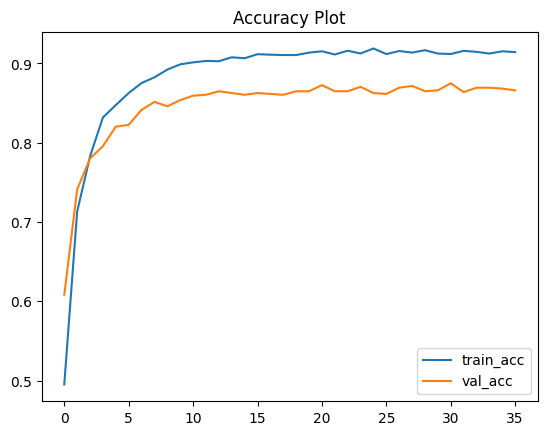

In [65]:
plt.title("Accuracy Plot")
plt.plot(train_accuracies, label="train_acc")
plt.plot(val_accuracies, label="val_acc")
plt.legend();

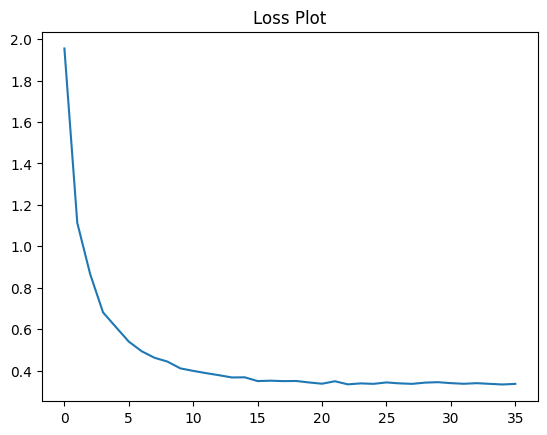

In [66]:
plt.title("Loss Plot")
plt.plot(train_losses)